In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from transformers import DistilBertTokenizer, DistilBertModel
import random
import datasets
import warnings
warnings.filterwarnings('ignore')

/home/lad1chka/HSE/DL/HSE_DL4/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
CONFIG = {
    'model_name': 'distilbert-base-uncased',
    'test_size': 0.2,
    'random_seed': 42,
    'max_length': 128,
    'batch_size': 8,
    'use_cuda': False,
}

In [3]:
dataset = datasets.load_dataset('imdb')

all_texts = dataset['train']['text']
all_labels = dataset['train']['label']

indices = list(range(len(all_texts)))
random.seed(CONFIG['random_seed'])
sampled_indices = random.sample(indices, 1000)

texts = [all_texts[i] for i in sampled_indices]
labels = [all_labels[i] for i in sampled_indices]

print(f"Size: {len(texts)}")
print(f"\positive: {texts[labels.index(1)][:100]}...")
print(f"negative: {texts[labels.index(0)][:100]}...")

Size: 1000
\positive: Arguably this is a very good "sequel", better than the first live action film 101 Dalmatians. It has...
negative: It's a good thing I didn't watch this while i was pregnant.I definitely would have cried my eyes out...


In [4]:
tokenizer = DistilBertTokenizer.from_pretrained(CONFIG['model_name'])
model = DistilBertModel.from_pretrained(CONFIG['model_name'], output_hidden_states=True)
model.eval()

if torch.cuda.is_available() and CONFIG['use_cuda']:
    model = model.cuda()
    print("GPU")
else:
    print(" CPU")

 CPU


In [5]:
def extract_all_layer_features(texts, labels):
    all_layer_features = {f'layer_{i}': [] for i in range(7)}
    all_labels = []
    
    with torch.no_grad():
        for i in range(0, len(texts), CONFIG['batch_size']):
            batch_texts = texts[i:i+CONFIG['batch_size']]
            batch_labels = labels[i:i+CONFIG['batch_size']]
            
            inputs = tokenizer(
                batch_texts,
                padding=True,
                truncation=True,
                max_length=CONFIG['max_length'],
                return_tensors='pt'
            )
            
            if torch.cuda.is_available() and CONFIG['use_cuda']:
                inputs = {k: v.cuda() for k, v in inputs.items()}
            
            outputs = model(**inputs)
            hidden_states = outputs.hidden_states
            
            for j in range(len(batch_texts)):
                all_labels.append(batch_labels[j])
                
                for layer_idx in range(len(hidden_states)):
                    cls_embedding = hidden_states[layer_idx][j, 0, :].cpu().numpy()
                    all_layer_features[f'layer_{layer_idx}'].append(cls_embedding)
    
    return all_layer_features, np.array(all_labels)

all_features, all_labels = extract_all_layer_features(texts, labels)
print(f"{len(all_features['layer_0'])} features")

1000 features


In [6]:
def evaluate_layer_classifier(features, labels, layer_name):
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, 
        test_size=CONFIG['test_size'],
        random_state=CONFIG['random_seed'],
        stratify=labels
    )

    clf = LogisticRegression(
        max_iter=1000,
        random_state=CONFIG['random_seed'],
        solver='lbfgs',
        C=1.0
    )
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy, clf

layer_results = []

for layer_idx in range(7):
    layer_name = f'layer_{layer_idx}'
    features = np.array(all_features[layer_name])
    
    accuracy, _ = evaluate_layer_classifier(features, all_labels, layer_name)
    
    layer_results.append({
        'layer': layer_idx,
        'accuracy': accuracy,
    })
    
    print(f"Layer_{layer_idx}: accuracy = {accuracy:.4f}")

results_df = pd.DataFrame(layer_results)


Layer_0: accuracy = 0.5000
Layer_1: accuracy = 0.7050
Layer_2: accuracy = 0.7150
Layer_3: accuracy = 0.7200
Layer_4: accuracy = 0.7400
Layer_5: accuracy = 0.7100
Layer_6: accuracy = 0.7750


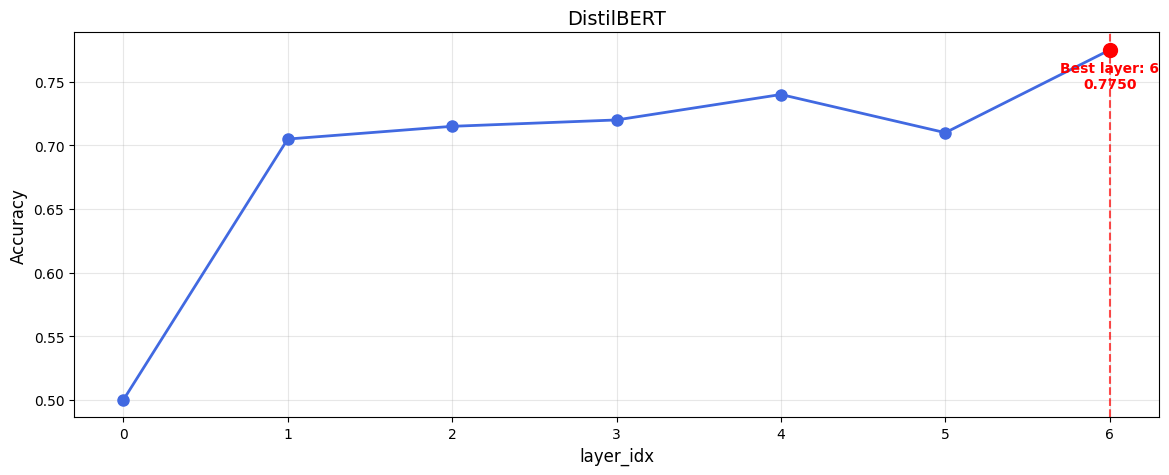

In [7]:
fig, (ax1) = plt.subplots(1, 1, figsize=(14, 5))

ax1.plot(results_df['layer'], results_df['accuracy'], marker='o', linewidth=2, markersize=8, color='royalblue')
ax1.set_xlabel('layer_idx', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('DistilBERT', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(range(7))

best_layer = results_df.loc[results_df['accuracy'].idxmax()]
ax1.axvline(x=best_layer['layer'], color='r', linestyle='--', alpha=0.7, linewidth=1.5)
ax1.plot(best_layer['layer'], best_layer['accuracy'], 'ro', markersize=10)
ax1.text(best_layer['layer'], best_layer['accuracy']-0.03, 
        f'Best layer: {int(best_layer["layer"])}\n{best_layer["accuracy"]:.4f}',
        ha='center', color='red', fontweight='bold')

plt.show()

In [8]:
# тестируем на датасете
test_indices = [0, 11, 22, 52] 
test_samples = [(texts[i][:150] + "...", labels[i]) for i in test_indices]

print("\nПримеры:")
for i, (text, true_label) in enumerate(test_samples):
    print(f"\nПример {i+1}:")
    print(f"Текст: {text}")
    print(f"Реальная метка: {'positive' if true_label == 1 else 'negative'}")

best_layer = results_df.loc[results_df['accuracy'].idxmax()]

best_layer_num = int(best_layer['layer'])
best_features = np.array(all_features[f'layer_{best_layer_num}'])

X_train, X_test, y_train, y_test = train_test_split(
    best_features, all_labels, 
    test_size=CONFIG['test_size'],
    random_state=CONFIG['random_seed'],
    stratify=all_labels
)

best_clf = LogisticRegression(max_iter=1000, random_state=CONFIG['random_seed'], solver='liblinear')
best_clf.fit(X_train, y_train)

print("\nПредсказания:")
for i, idx in enumerate(test_indices):
    features = np.array(all_features[f'layer_{best_layer_num}'][idx]).reshape(1, -1)
    prediction = best_clf.predict(features)[0]
    proba = best_clf.predict_proba(features)[0]
    
    print(f"\nПример {i+1}:")
    print(f"Предсказание: {'positive' if prediction == 1 else 'negative'}")
    print(f"Уверенность: {max(proba):.3f}")
    print(f"Вероятности: негативный={proba[0]:.3f}, позитивный={proba[1]:.3f}")


Примеры:

Пример 1:
Текст: Arguably this is a very good "sequel", better than the first live action film 101 Dalmatians. It has good dogs, good actors, good jokes and all right ...
Реальная метка: positive

Пример 2:
Текст: Lexi befriends Jennifer, a thin, intelligent girl at her new school. Lexi's parents have just split up. Soon, Jen tells Lexi of her eating disorder, a...
Реальная метка: positive

Пример 3:
Текст: To Die For has it all.This film has a great cast. Lots and lots of romance and terror. Not too gory but still enough to appeal to horror fans. There a...
Реальная метка: positive

Пример 4:
Текст: This was a watchable movie, but plot was a little weak and most of the jokes were from some of Rodney's earlier movies. With that said, it was worth t...
Реальная метка: negative

Предсказания:

Пример 1:
Предсказание: negative
Уверенность: 0.521
Вероятности: негативный=0.521, позитивный=0.479

Пример 2:
Предсказание: positive
Уверенность: 0.841
Вероятности: негативный=0.159, по

Заметим, что:
Наиболее информативные признаки находятся в промежуточных слоях, однако всё же последний слой получил наибольшую точность
В HiProbe-VAD: лучшие слои для VAD - средние слои MLLM, в нашем эксперименте: хорошие слои для текстовой классификации - 3-4 слои, но 6 слой лучший
Это происходит потому что DistilBertModel содержит финальную нормализацию и проекцию и в ней оптимизирован финальный слой